In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix


from imblearn.over_sampling import SMOTE

import matplotlib.pyplot as plt
import seaborn as sns


In [2]:
df_train = pd.read_csv("train_data_with_traffic_class.csv")  #training dataset
df_test = pd.read_csv("test_data_with_traffic_class.csv") #testing dataset

In [3]:
# Define target and features
X = df_train.drop(columns=["Total_Traffic", "Departures", "Arrivals", "Traffic_Class", "Month"])  # Features
# Encode categorical variables
X = pd.get_dummies(X, columns=["Country"], drop_first=True)  # One-hot encoding
y = df_train["Traffic_Class"]  # Target

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) 

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Train Random Forest
clf = RandomForestClassifier(class_weight='balanced' ,random_state=42)

clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))


Accuracy: 0.9697986577181208


Accuracy: 0.6748329621380846
Classification Report (Test):
              precision    recall  f1-score   support

           0       0.62      1.00      0.76       229
           1       1.00      0.58      0.74        43
           2       0.91      0.28      0.42       177

    accuracy                           0.67       449
   macro avg       0.84      0.62      0.64       449
weighted avg       0.77      0.67      0.63       449



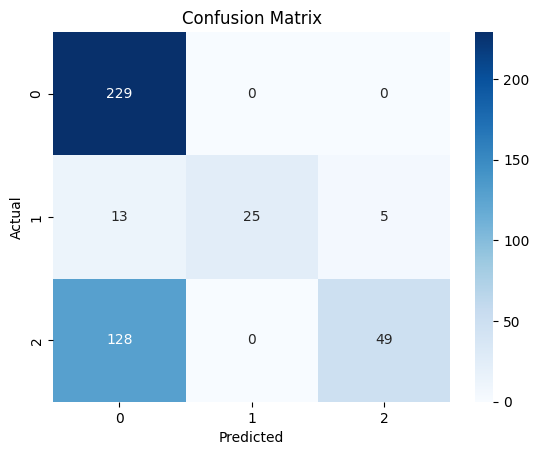

In [4]:
# Define target and features
X_test2 = df_test.drop(columns=["Total_Traffic", "Departures", "Arrivals", "Traffic_Class", "Month"])  # Features
y_test2 = df_test["Traffic_Class"]  # Target

# Encode categorical variables
X_test2 = pd.get_dummies(X_test2, columns=["Country"], drop_first=True)  # One-hot encoding

X_test_scaled = scaler.transform(X_test2)

# Extract true labels
y_test2 = df_test["Traffic_Class"] 

# Predict and evaluate
y_pred2 = clf.predict(X_test_scaled)
print("Accuracy:", accuracy_score(y_test2, y_pred2))

from sklearn.metrics import classification_report, confusion_matrix

# Classification Report
print("Classification Report (Test):")
print(classification_report(y_test2, y_pred2))

# Confusion Matrix
cm = confusion_matrix(y_test2, y_pred2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


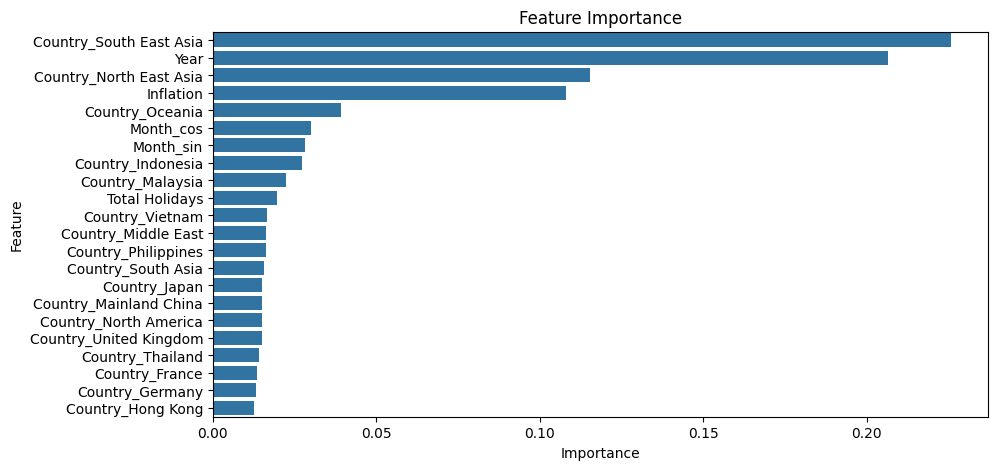

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importance
feature_importance = clf.feature_importances_

# Create a DataFrame for visualization
feat_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importance})
feat_df = feat_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 5))
sns.barplot(x='Importance', y='Feature', data=feat_df)
plt.title("Feature Importance")
plt.show()


Fine-Tuning the Hyperparameters:

n_estimators - Specifies the number of decision trees
Higher values can increase model stability and reduces variance.

max_depth - Limits how deep each decision tree can grow
Higher depth captures more complex patterns

max_features - Determines how many features are randomly selected at each split.
min_samples_split - The minimum number of samples required to split an internal node in a decision tree
Higher values prevent overfitting

min_samples_leaf - The minimum number of samples that must be present in a leaf node
Setting a higher leaf size ensures the model focuses on meaningful patterns rather than noise.

max_samples - The proportion of the dataset sampled for each tree
By lowering the values, increases tree diversity and reduce overfitting

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define hyperparameter grid
param_grid = {
    "n_estimators": [50, 75, 100],  
    "max_depth": [5, 10, 15],  
    "max_features": ["sqrt", "log2"],  
    "min_samples_split": [10, 20, 30],  
    "min_samples_leaf": [5, 10, 15],  
    "max_samples": [0.7, 0.8, 0.9]  
}

# Set up GridSearchCV with cross-validation (cv=5 for 5-fold cross-validation)
grid_search = GridSearchCV(estimator=clf, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)

# Fit the model with grid search
grid_search.fit(X_train, y_train)

# Best hyperparameters found by GridSearchCV
print("Best Hyperparameters:", grid_search.best_params_)

# Train model with best hyperparameters
best_rf = grid_search.best_estimator_


Fitting 5 folds for each of 486 candidates, totalling 2430 fits
Best Hyperparameters: {'max_depth': 15, 'max_features': 'sqrt', 'max_samples': 0.8, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 50}


In [12]:
# Best hyperparameters
print(f"Best Hyperparameters: {grid_search.best_params_}")

# Use the best model found by grid search to make predictions
y_train_pred = best_rf.predict(X_train)
y_test_pred = best_rf.predict(X_test_scaled)

from sklearn.metrics import accuracy_score

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test2, y_test_pred)

train_balanced_acc = balanced_accuracy_score(y_train, y_train_pred)
test_balanced_acc = balanced_accuracy_score(y_test2, y_test_pred)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

print(f"Train Balanced Accuracy: {train_acc:.4f}")
print(f"Test Balanced Accuracy: {test_acc:.4f}")


Best Hyperparameters: {'max_depth': 15, 'max_features': 'sqrt', 'max_samples': 0.8, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 50}
Train Accuracy: 0.9465
Test Accuracy: 0.8641
Train Balanced Accuracy: 0.9465
Test Balanced Accuracy: 0.8641


In [8]:
#try with randomsearch
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define hyperparameter 
param_dist = {
    "n_estimators": [50, 75, 100],  # Reduce number of trees
    "max_depth": [5, 10, 15],  # Reduce depth
    "max_features": ["sqrt", "log2"],  # Feature selection
    "min_samples_split": [10, 20, 30],  # Increase minimum split
    "min_samples_leaf": [5, 10, 15],  # Increase leaf size
    "max_samples": [0.7, 0.8, 0.9]  # Reduce sampling per tree
}


# Set up GridSearchCV with cross-validation (cv=5 for 5-fold cross-validation)
random_search =  RandomizedSearchCV(
    clf, param_distributions=param_dist, n_iter=100, cv=5, scoring='accuracy', n_jobs=-1, random_state=42
)

# Fit the model with grid search
random_search.fit(X_train, y_train)

# Best hyperparameters found by GridSearchCV
print("Best Hyperparameters:", random_search.best_params_)

# Train model with best hyperparameters
best_rf_random = random_search.best_estimator_


Best Hyperparameters: {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_samples': 0.7, 'max_features': 'sqrt', 'max_depth': 15}


In [9]:
# Best hyperparameters
print(f"Best Hyperparameters: {random_search.best_params_}")

# Use the best model found by grid search to make predictions
y_train_pred = best_rf_random.predict(X_train)
y_test_pred = best_rf_random.predict(X_test_scaled)

from sklearn.metrics import accuracy_score

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test2, y_test_pred)

train_balanced_acc = balanced_accuracy_score(y_train, y_train_pred)
test_balanced_acc = balanced_accuracy_score(y_test2, y_test_pred)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

print(f"Train Balanced Accuracy: {train_acc:.4f}")
print(f"Test Balanced Accuracy: {test_acc:.4f}")


Best Hyperparameters: {'n_estimators': 50, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_samples': 0.7, 'max_features': 'sqrt', 'max_depth': 15}
Train Accuracy: 0.9456
Test Accuracy: 0.8330
Train Balanced Accuracy: 0.9456
Test Balanced Accuracy: 0.8330


In [10]:
from sklearn.model_selection import cross_val_score

# Perform k-fold cross-validation with the best model
cv_scores = cross_val_score(best_rf, X_train, y_train, cv=10, scoring='accuracy') #10-fold

print(f"Cross-Validation Scores: {cv_scores}")
print(f"Mean Cross-Validation Accuracy: {cv_scores.mean():.4f}")


Cross-Validation Scores: [0.92241379 0.94827586 0.9137931  0.93390805 0.92528736 0.96551724
 0.91930836 0.93371758 0.93083573 0.92795389]
Mean Cross-Validation Accuracy: 0.9321


Classification Report (Test):
              precision    recall  f1-score   support

           0       0.81      1.00      0.89       229
           1       0.86      1.00      0.92        43
           2       1.00      0.66      0.79       177

    accuracy                           0.86       449
   macro avg       0.89      0.89      0.87       449
weighted avg       0.89      0.86      0.86       449



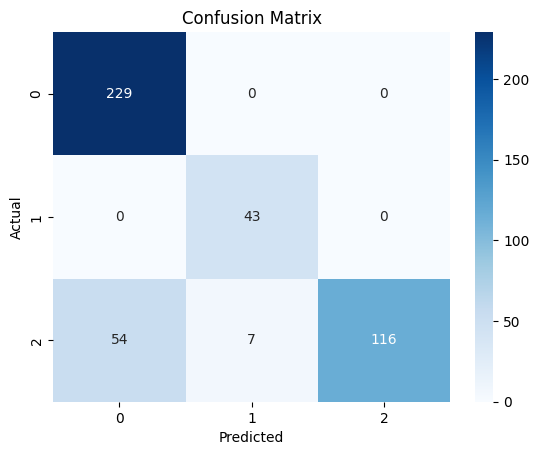

In [13]:

from sklearn.metrics import classification_report, confusion_matrix

# Classification Report
print("Classification Report (Test):")
print(classification_report(y_test2, y_test_pred))

# Confusion Matrix
cm = confusion_matrix(y_test2, y_test_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [29]:
# Save Traffic_Class to train and test CSV files - final one

# Save the train DataFrame with the new Traffic_Class column
df_train.to_csv('train_data_with_traffic_class.csv', index=False)

# Save the test DataFrame with the new Traffic_Class column
df_test.to_csv('test_data_with_traffic_class.csv', index=False)

print("Files saved with Traffic_Class column!")

Files saved with Traffic_Class column!


To understand the model better, I implemented the use of Shapley Additive Explanations (SHAP) to help interpret the model. 
SHAP values are useful in showing how each feature contributes to the prediction of the model. 

In [31]:
import shap 
# Create the SHAP explainer for the Random Forest model
explainer = shap.TreeExplainer(best_rf)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test_scaled)
print("SHAP values shape:", np.array(shap_values).shape)
print("X_test_scaled shape:", X_test_scaled.shape)

# Generate a SHAP summary plot
#shap.summary_plot(shap_values[1], X_test)

SHAP values shape: (449, 22, 3)
X_test_scaled shape: (449, 22)


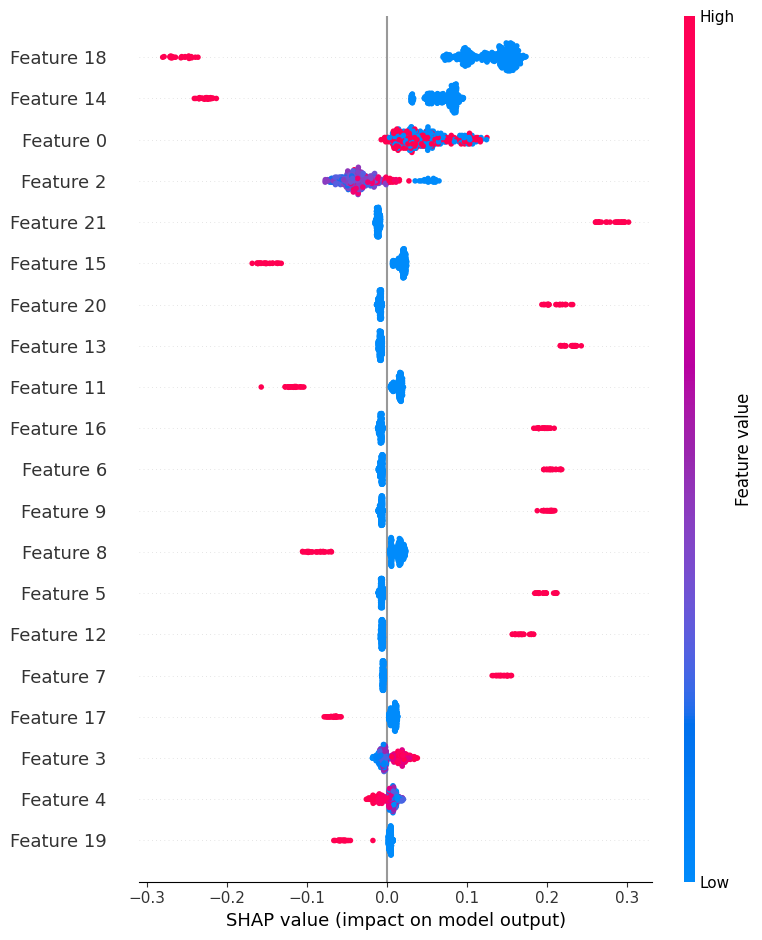

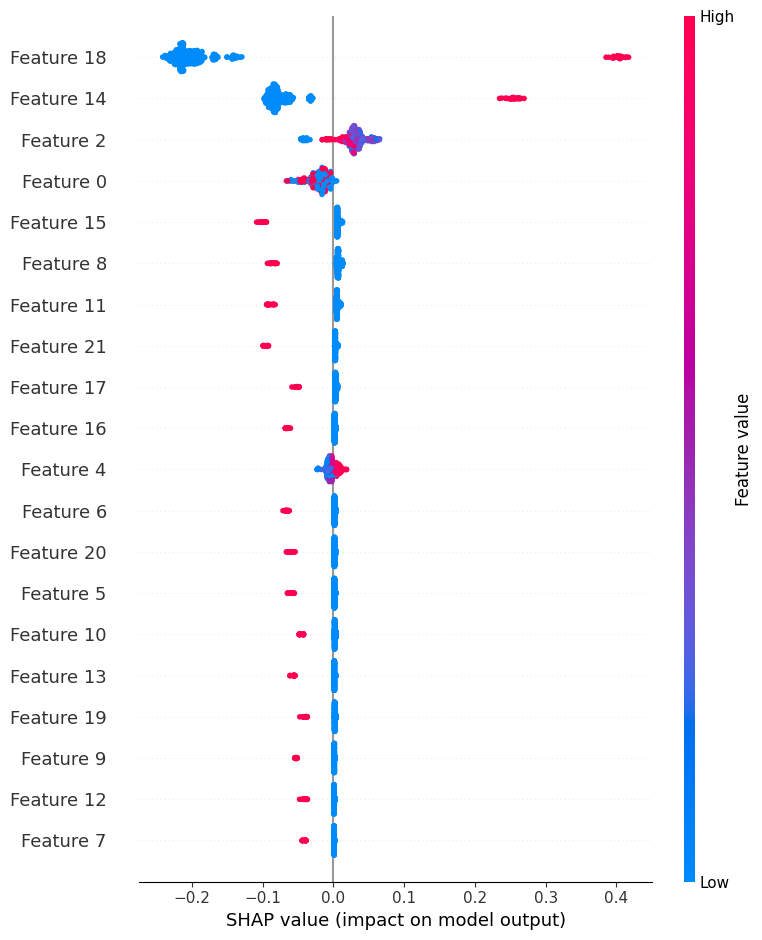

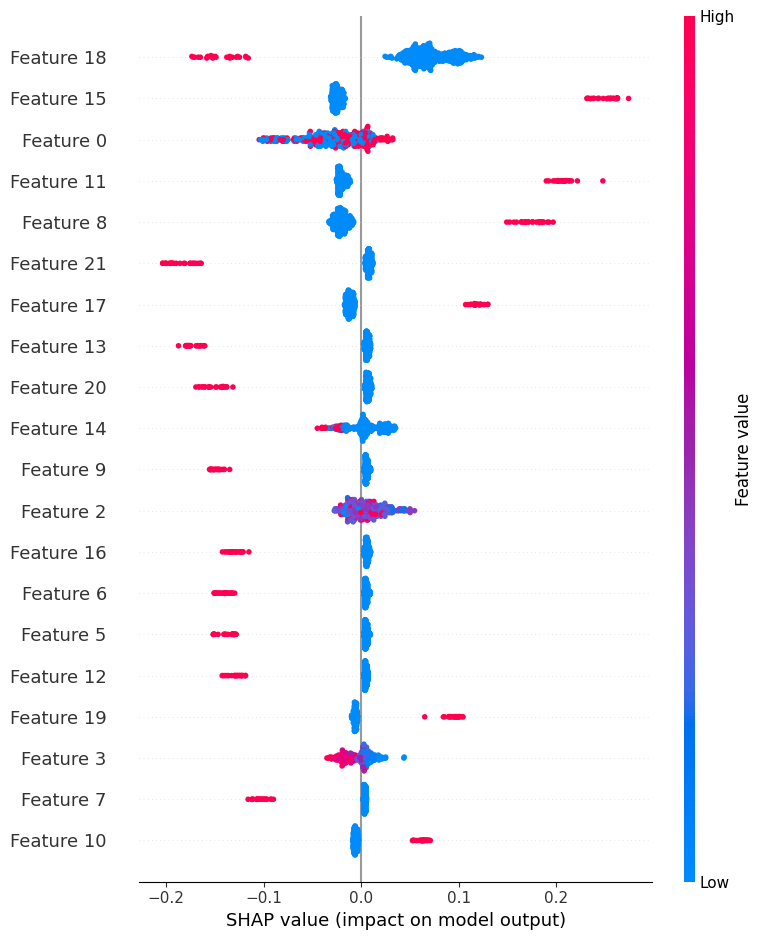

In [32]:
import shap

# SHAP values for class 0
shap.summary_plot(shap_values[:, :, 0], X_test_scaled)

# SHAP values for class 1
shap.summary_plot(shap_values[:, :, 1], X_test_scaled)

# SHAP values for class 2
shap.summary_plot(shap_values[:, :, 2], X_test_scaled)


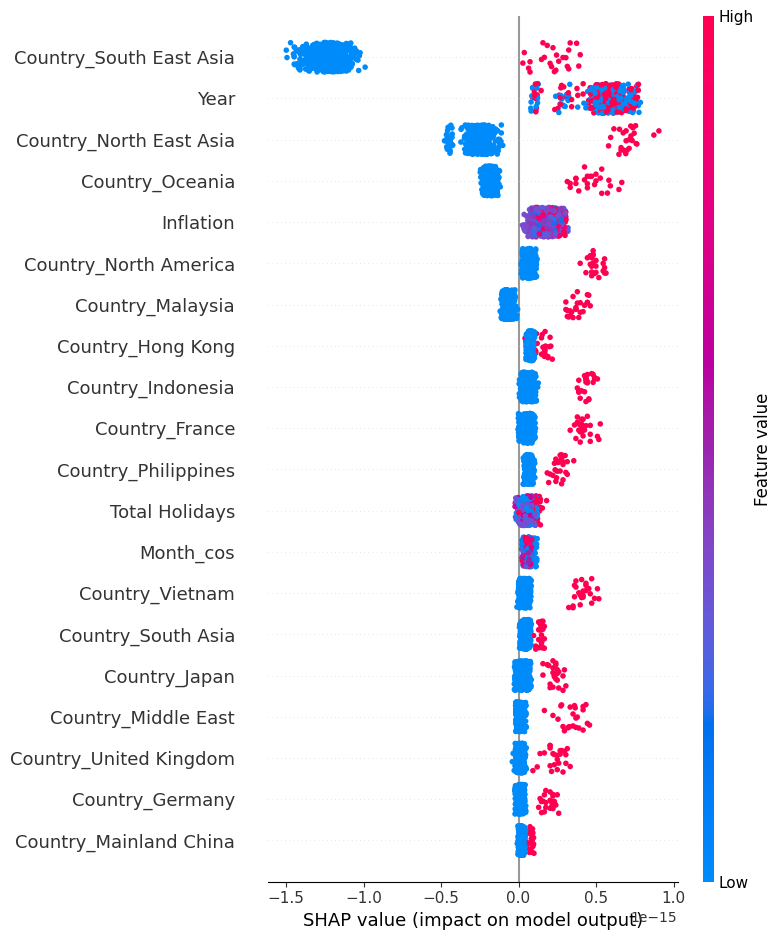

In [ ]:
# Convert back to DataFrame with original feature names
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test2.columns)

# SHAP summary plot with feature names
shap.summary_plot(shap_values.mean(axis=2), X_test_scaled_df)


For the Y-Axis:

Each row represents a feature, such as Country_South East Asia, Year, and Inflation.

Features at the top have the highest importance (largest impact on predictions).

For the X-Axis:

The SHAP value shows how much a feature contributes to increasing or decreasing the model's output.

Negative SHAP values (towards the left) results to decrease in prediction.

Positive SHAP values (towards the right) results to increase in prediction.

Blue indicates low feature values (e.g. a small inflation rate).
Red indicates high feature values (e.g. a high inflation rate).

From this graph, we can infer that Country_South East Asia has a strong influence on predictions, with mostly negative SHAP values. Year also has a significant impact, but values are spread between positive and negative influences.
Country_North East Asia, Country_Oceania, and Inflation have varying effects, suggesting their influence depends on the instance.

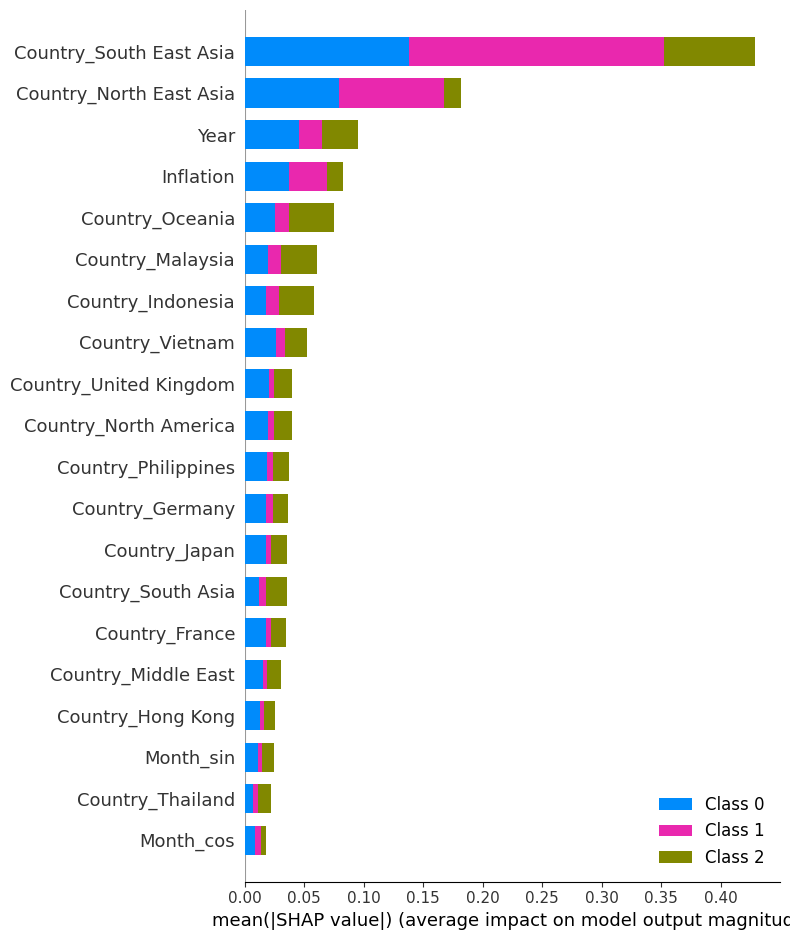

In [34]:
shap.summary_plot(shap_values, X_test_scaled, feature_names=X_test2.columns, plot_type="bar")


A SHAP force plot is used to explain individual predictions made by a model. It helps us understand which features increased or decreased the prediction for a specific instance. It also enable us to see how much each feature contributed to pushing the prediction higher or lower.

In our case, it is useful in understanding which features increase or decrease traffic.

(449, 22)
(449, 22, 3)


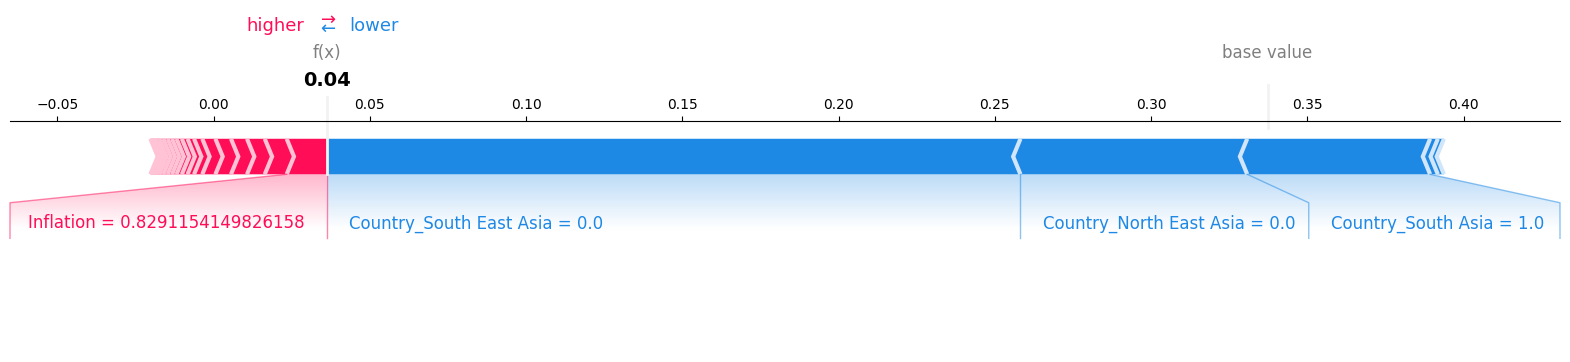

In [ ]:
#force plot

# X_test is a NumPy array, convert it to a pandas DataFrame for easier indexing
X_test_df = pd.DataFrame(X_test2, columns=X_test2.columns)  # X_test2.columns contains feature names

# Verify the shapes of the data
print(X_test_df.shape)
print(shap_values.shape)  

class_index = 1  #looking at cluster 1

# Get the SHAP values for the chosen cluster
shap_values_class = shap_values[:, :, class_index]

# Get the expected value for this class
expected_value_class = explainer.expected_value[class_index]

# Select the 6th instance for checking
instance_idx = 6

# Generate the SHAP force plot for this specific instance
shap.plots.force(expected_value_class, shap_values_class[instance_idx, :], X_test_df.iloc[instance_idx, :], matplotlib=True)


The force plot above shows that inflation has a strong negative SHAP value, meaning higher inflation reduces the predicted traffic volume. Country_South East Asia, Country_North East Asia and Country_South_Asia features on the other hand positively influence the prediction.
This suggests that locations in these regions generally see higher traffic volumes—but in this specific case, inflation is counteracting that effect.

Next, we will plot the top 5 features in each cluster. These bar charts will represent the top 5 most influential features for each class based on their mean absolute SHAP values. Higher SHAP values indicate a stronger impact on the model's predictions for that class.

In [ ]:
import numpy as np
import shap
import matplotlib.pyplot as plt

# Compute mean absolute SHAP values for each cluster
num_classes = shap_values.shape[2]  
feature_importance_per_class = {}

for class_idx in range(num_classes):
    mean_abs_shap = np.abs(shap_values[:, :, class_idx]).mean(axis=0)  # Mean absolute SHAP per feature
    feature_importance_per_class[class_idx] = mean_abs_shap

# Get feature names
feature_names = X_test2.columns.tolist()

# Store top 5 features for each class
top_features_per_class = {}

for class_idx in range(num_classes):
    top_indices = np.argsort(feature_importance_per_class[class_idx])[-5:]  # Get top 5 feature indices
    top_features_per_class[class_idx] = [feature_names[i] for i in top_indices]


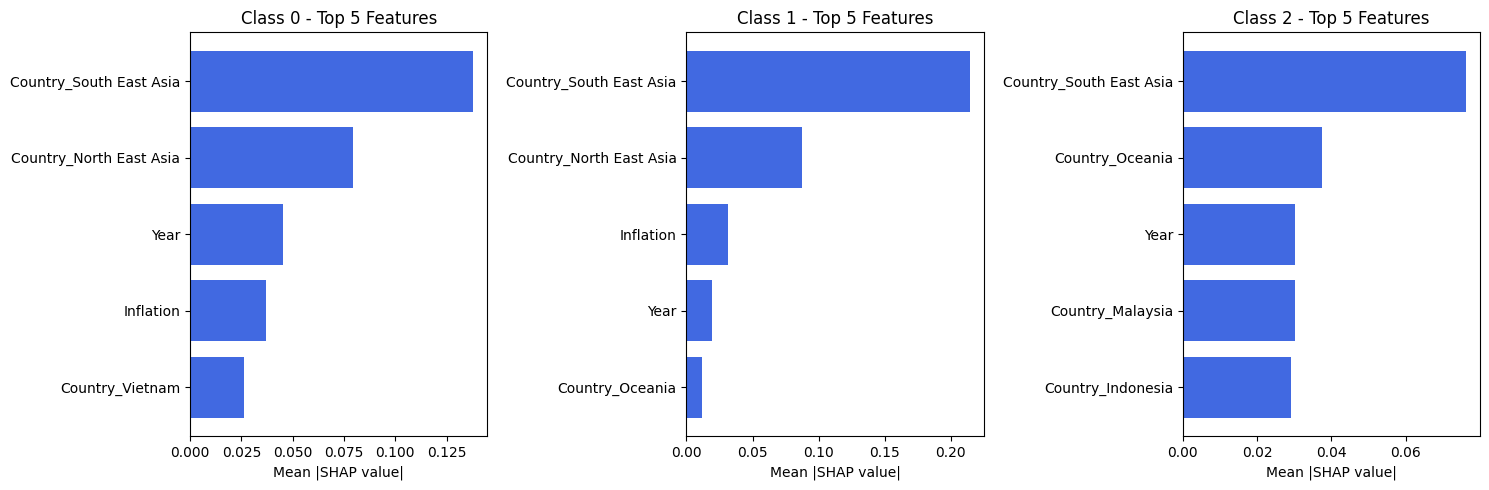

In [100]:
fig, axes = plt.subplots(1, num_classes, figsize=(15, 5))

for class_idx in range(num_classes):
    top_features = top_features_per_class[class_idx]
    top_importance = feature_importance_per_class[class_idx][np.argsort(feature_importance_per_class[class_idx])[-5:]]
    
    ax = axes[class_idx]
    ax.barh(top_features, top_importance, color='royalblue')
    ax.set_xlabel("Mean |SHAP value|")
    ax.set_title(f"Class {class_idx} - Top 5 Features")

plt.tight_layout()
plt.show()


Observations:

"Country_South East Asia" is the most important feature across all classes.

This suggests that whether a country is in South East Asia strongly influences the model's classification.
The impact is highest for Class 1 and Class 2, meaning the model highly relies on this feature when predicting those classes.

"Year" is consistently present among the top features.

This suggests that the time period impacts predictions across all classes.
It might be that trends over time influence the classifications.

Inflation is important for Class 0 and Class 1 but not for Class 2.

This means inflation likely plays a role in differentiating Class 0 vs. Class 1.
However, Class 2 seems less influenced by inflation.

Findings (in business context):

How features affects 'traffic_class'
+ Geographical features play a huge role in the prediction. 

Countries in South East Asia and North East Asia play the biggest role in determining traffic_class.
This suggests that regional airport activity, air traffic regulations, and demand patterns strongly influence the classification.

+ Macroeconomic Factors (Inflation) Influence Traffic:

Inflation affects passenger behavior, potentially impacting airline ticket sales, operational costs, and demand.
A high inflation rate might correlate with lower air traffic due to increased travel costs.

+ Time Trends Matter:

Year influences classification, meaning that economic cycles, or pandemic-related impacts may have shaped air traffic patterns.
Month_sin (seasonality effect) has a minor impact but still contributes to seasonal fluctuations in air travel.

Conclusion & Business Insights:
- Geographic region is the strongest factor in traffic classification

Policymakers and airline companies in these regions can use this insight to optimize flight routes and airport operations.

- Macroeconomic conditions impact traffic patterns

Inflation plays a role in classification, suggesting that economic downturns or price fluctuations influence flight demand.
Airlines can adjust pricing strategies based on economic trends.

- Time-Based Trends Indicate Evolving Traffic Patterns

Year affects classification, showing that traffic patterns change over time due to external events, regulatory changes, or technology advancements.
This insight is valuable for predicting future trends in air travel.

Future Actionable Steps for Stakeholders

✔ Airlines should optimize their pricing models based on regional economic conditions.

✔ Airport authorities should monitor geographic traffic trends and allocate resources accordingly.

✔ Future models should incorporate more dynamic time-based variables to improve predictions.

